In [289]:
import numpy as np
import pandas as pd
import seaborn as sns

In [290]:
df = pd.read_csv("Data_120294_2023-03-29.csv")


/var/folders/k_/917q0lsn2g199rm9y4s8jy5h0000gn/T/ipykernel_50609/2197491256.py:1: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data_120294_2023-03-29.csv")


## Choosing features and y
choosing which features should included in the model

In [291]:
#Choosing the columns that we want to use
relevant_colums = ["init_age", "gender", "abo", "pramr", "prapk", "hemo_pcw_tcr", "hemo_pa_mn_tcr", "bmi_tcr",
                   "init_date", "tx_date"]

df = df[relevant_colums]

In [292]:
# Illustrate the data set of the chosen features with 15 random rows
df.sample(15)

,init_age,gender,abo,pramr,prapk,hemo_pcw_tcr,hemo_pa_mn_tcr,bmi_tcr,init_date,tx_date
34903,55.0,F,O,NaN,NaN,20.0,35.0,20.4048,16aug1996,NaN
96334,52.0,M,A,NaN,NaN,11.0,17.0,27.7778,04oct2013,19feb2014
107828,68.0,M,O,NaN,NaN,20.0,26.0,19.7662,18jul2017,18aug2017
83091,39.0,F,O,NaN,NaN,10.0,15.0,24.0307,27jan2006,22feb2009
57953,61.0,M,O,0.0,0.0,NaN,NaN,26.5888,30aug1988,17sep1988
56744,58.0,M,A,NaN,NaN,14.0,24.0,27.9768,10may2006,19jan2008
23112,52.0,M,A,NaN,NaN,11.0,18.0,24.3025,26may1995,NaN
110918,51.0,M,A,NaN,NaN,28.0,34.0,26.9511,17may2018,10jun2018
77419,39.0,F,A,0.0,0.0,28.0,35.0,32.3232,22may1996,10apr1999
117231,31.0,M,A,3.0,21.0,NaN,21.0,24.1409,18jun1999,11sep1999


In [293]:
#Display some basic info about the chosen features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120264 entries, 0 to 120263
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   init_age        120257 non-null  float64
 1   gender          120264 non-null  object 
 2   abo             120264 non-null  object 
 3   pramr           32023 non-null   float64
 4   prapk           30295 non-null   float64
 5   hemo_pcw_tcr    80933 non-null   float64
 6   hemo_pa_mn_tcr  83439 non-null   float64
 7   bmi_tcr         115677 non-null  float64
 8   init_date       120264 non-null  object 
 9   tx_date         77410 non-null   object 
dtypes: float64(6), object(4)
memory usage: 9.2+ MB


## Data preprocessing (cleaning) and data analysis

#### tx_date
Before we start analyzing the data, we remove all rows which do not have tx_date. We are predicting time until transplant, and the rows which do not have a transplant date are therefore irrelevant.

In [294]:
original_size = len(df)

#Print number of rows before removing rows without tx_date
print("Number of rows before removing rows without tx_date: ", original_size)

#Remove all rows without tx_date
df = df[df["tx_date"].notna()]

size_post_cleaning = len(df)
#Print number of rows after removing rows without tx_date
print("Number of rows after removing rows without tx_date: ", size_post_cleaning)

#Print number of removed rows as number
print("Number of removed rows: ", original_size - size_post_cleaning)




Number of rows before removing rows without tx_date:  120264
Number of rows after removing rows without tx_date:  77410
Number of removed rows:  42854


#### Handling of duplicate values

In [295]:
#Display information about the duplicates
df[df.duplicated()]

,init_age,gender,abo,pramr,prapk,hemo_pcw_tcr,hemo_pa_mn_tcr,bmi_tcr,init_date,tx_date


In [296]:
#Count number of duplicates
print("Number of duplicates: ", df.duplicated().sum())

#Number of duplicates before dropping
print("Number of rows before dropping duplicates: ", df.shape[0])
#Drop duplicates and keep the first occurence
df = df.drop_duplicates()

#Number of duplicates after dropping
print("Number of rows after dropping duplicates: ", df.shape[0])

Number of duplicates:  0
Number of rows before dropping duplicates:  77410
Number of rows after dropping duplicates:  77410


### Handling and analysis of missing values

In [297]:
#Display percentage of missing values for each feature
df.isnull().sum() / df.shape[0] * 100


init_age           0.000000
gender             0.000000
abo                0.000000
pramr             58.631960
prapk             60.864229
hemo_pcw_tcr      30.565818
hemo_pa_mn_tcr    28.482108
bmi_tcr            1.993283
init_date          0.000000
tx_date            0.000000
dtype: float64

pramr and prapk have a lot of missing values and may need to be dropped.
It may also be relevant to only keep the rows which have a tx_date, as the others can be considered to not have received a transplant for various reasons such as death. Imputation is needed on features with a lot of missing values.

#### bmi_tcr
As there are only less than 2% of values missing a bmi_tcr, they are removed.

In [298]:
#Print number of rows before removing rows with missing bmi_tcr
print("Number of rows before removing rows with missing bmi_tcr: ", len(df))

#Remove all rows with missing bmi_tcr
df = df[df["bmi_tcr"].notna()]

#Print number of rows after removing rows with missing bmi_tcr
print("Number of rows after removing rows with missing bmi_tcr: ", len(df))

Number of rows before removing rows with missing bmi_tcr:  77410
Number of rows after removing rows with missing bmi_tcr:  75867


In [299]:
#Remove all entries with missing values
#df = df.dropna()

# Use simple imputer instead of .dropna to impute missing values


#Display percentage of missing values for each feature
print(df.isnull().sum() / df.shape[0] * 100)

#Print number of rows
print("Number of rows: ", df.shape[0])

init_age           0.000000
gender             0.000000
abo                0.000000
pramr             59.361778
prapk             61.387692
hemo_pcw_tcr      29.595213
hemo_pa_mn_tcr    27.478350
bmi_tcr            0.000000
init_date          0.000000
tx_date            0.000000
dtype: float64
Number of rows:  75867


#### Wait list time (wl_time) - Y
Creating the value to be predicted, namely wl_time by calculating the difference between init_date and tx_date, and adding it to a column called wl_time. Thereafter they are dropped (maybe they shouldn't be dropped as they can be used as features?). 

In [300]:
df['wl_time'] = (
            pd.to_datetime(df['tx_date'], format='%d%b%Y') - pd.to_datetime(df['init_date'], format='%d%b%Y')).dt.days

# drop init_date and end_date
df = df.drop(['init_date', 'tx_date'], axis=1)

Data visualisation and analysis on wl_time

Number of values less than 10 in wl_time:  9365
79.0


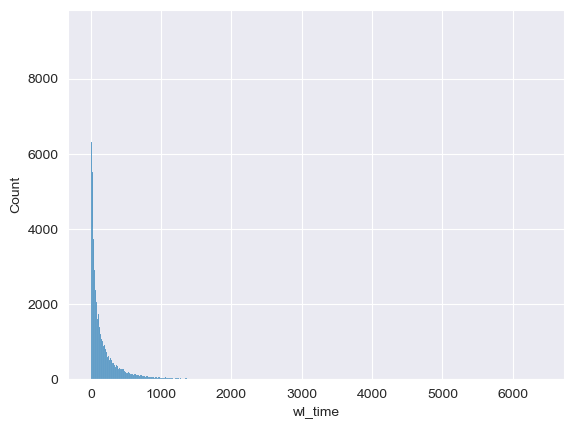

In [301]:
#Display a histogram plot of wl_time using sns
sns.histplot(data=df, x="wl_time")

#print the number of values that are less than 10 in wl_time
print("Number of values less than 10 in wl_time: ", len(df[df['wl_time'] < 10]))

#Print the median of the wl_time
median_wl_time = df['wl_time'].median()
print(median_wl_time)

Number of values that are outliers in wl_time:  7513
Number of values that are not outliers in wl_time:  68354


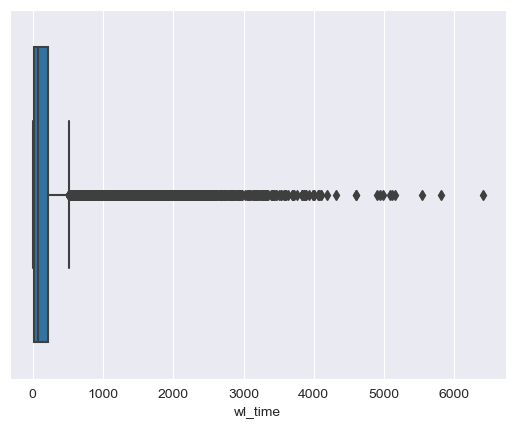

In [302]:
#Display a boxplot of the distribution of the wl_time using sns
sns.boxplot(data=df, x="wl_time")

#Print the number of values that that are outliers, meaning they are bigger than 500
print("Number of values that are outliers in wl_time: ", len(df[df['wl_time'] > 500]))
#Print the number of values that are not outliers, meaning they are between 0 and 500
print("Number of values that are not outliers in wl_time: ", len(df[df['wl_time'] <= 500]))


## Transforming
- Drop redundant columns

## Encode

In [303]:
# encode categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

le = LabelEncoder()
df["abo"] = le.fit_transform(df["abo"])
df["gender"] = le.fit_transform(df["gender"])

#This should be moved to proper place later
#Calculate median wl_time


# we want to predict if it took more or less than 60 days to get a transplant
df['wl_time'] = df['wl_time'].apply(lambda x: 1 if x > 30 * 6 else 0)

#for col in df.columns:
#    if df[col].dtype == 'object':
#        df[col] = le.fit_transform(df[col])

features = ["init_age", "bmi_tcr", "pramr", "prapk", "hemo_pcw_tcr", "hemo_pa_mn_tcr"]
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Impute missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


median_wl_time:  79.0


## Build model

In [304]:

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

assert df.isnull().sum().sum() == 0, "There are still missing values in the dataset"

X_train, X_test, y_train, y_test = train_test_split(df.drop('wl_time', axis=1), df['wl_time'], test_size=0.3,
                                                    random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))

model = Sequential([
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="linear")
])

# compile the model
#model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

y_pred = model.predict(X_test)



Logistic Regression Accuracy:  0.5629366020825095
Epoch 1/300
6639/6639 [==============================] - 3s 449us/step - loss: 0.7743 - accuracy: 0.5534
Epoch 2/300
6639/6639 [==============================] - 3s 452us/step - loss: 0.6764 - accuracy: 0.5785
Epoch 3/300
6639/6639 [==============================] - 3s 445us/step - loss: 0.6733 - accuracy: 0.5861
Epoch 4/300
6461/6639 [============================>.] - ETA: 0s - loss: 0.6714 - accuracy: 0.5908

KeyboardInterrupt: 